In [1230]:
import pandas as pd
from corre import  CorrMtx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tseries_processing as ts
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np

In [1231]:
def eliminar_autocorr(df,dep,corr_max=0.50):
    ind=df.copy()
    a_eliminar=[]
    for variable_1 in ind.columns:
        for variable_2 in ind.columns:
            #print('Variable 1: ',variable_1,' y Variable 2: ',variable_2)
            #print(pearsonr(ind[variable_1],ind[variable_2]))
            #print('Correlacion de la variable 1 con gasto: ',pearsonr(ind[variable_1],ind['GastProvCarteraInd']))
            #print('Correlacion de la variable 2 con gasto: ',pearsonr(ind[variable_2],ind['GastProvCarteraInd']))
            try:
                if  pearsonr(ind[variable_1],ind[variable_2])[0]>corr_max and variable_1 != variable_2  and (variable_1 != dep and variable_2 != dep):
                    if abs(pearsonr(ind[variable_1],ind[dep])[0]) > abs(pearsonr(ind[variable_2],ind[dep])[0]):       
                        print('A eliminar: ',variable_2)
                        print('Por: ',variable_1)
                        print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                        a_eliminar.append(variable_2)
                    else:
                        print('A eliminar: ',variable_1)
                        print('Por: ',variable_2)
                        print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                        a_eliminar.append(variable_1)
            except:
                pass
    a_eliminar=pd.Series(a_eliminar)
    a_eliminar= a_eliminar.unique()
    return a_eliminar

In [1232]:
plt.rcParams["figure.figsize"] = (20,20)
#import matplotlib.style
#import matplotlib as mpl
#mpl.style.use('classic')

# <<<< Gasto de Provisiones Individual >>>>

In [1233]:
ind=pd.read_csv('ind.csv')

In [1234]:
ind.set_index('Unnamed: 0',inplace=True)

# Método JJ

In [1235]:
corr=[]
p=[]
var=[]
for variable in ind.columns:
    try:
        var.append(variable)
        corr.append(pearsonr(ind[variable],ind['GastProvCarteraInd'])[0])
        p.append(pearsonr(ind[variable],ind['GastProvCarteraInd'])[1])
    except:
        pass

dat=pd.DataFrame()
dat['variables']=var
dat['corr']=corr
dat['p']=p

In [1236]:
dat

,variables,corr,p
0,credito_sector_privado,0.442339,2.002482e-04
1,DIsI_avg_12,-0.325389,7.677444e-03
2,DIcP_avg_12,0.455154,1.231662e-04
3,inflacion,0.574637,4.522366e-07
4,TC,-0.450140,1.493008e-04
5,tasa_ref,0.205898,9.719911e-02
6,PBI_avg_12,-0.399824,8.809559e-04
7,GastProvCarteraInd,1.000000,0.000000e+00
8,Confianza Consumidor,0.584926,2.503127e-07
9,TIAPSF,0.286219,1.981703e-02


In [1237]:
#dat.to_excel('correla.xlsx')

Elminando por correlación no significativa

In [1238]:
a_eliminar=[]
for variable in ind.columns:
    try:
       # print('------',variable,'------')
       # print(pearsonr(ind[variable],ind['GastProvCarteraInd']))
        if  pearsonr(ind[variable],ind['GastProvCarteraInd'])[1]>0.05:
            a_eliminar.append(variable)
    except:
        pass
print('Variables a eliminar: ',a_eliminar)

Variables a eliminar:  ['tasa_ref', 'consumo _cemento', 'Agropecuario', 'Pesca']


In [1239]:
ind.drop(a_eliminar,axis=1,inplace=True)

Eliminando por variables inversas

In [1240]:
a_eliminar=['DIsI_avg_12','DIcP_avg_12','Confianza Consumidor','Minería_hidrocarburos','Electricidad','Comercio','Otros_servicios','credito_sector_privado']

In [1241]:
ind.drop(a_eliminar,axis=1,inplace=True)

Rezagando

In [1242]:
#ind=ts.rezagar(ind,n=3,diferencias=False) # Hasta 2 rezago

In [1243]:
#ind.dropna(inplace=True)

In [1244]:
ind.columns

Index(['inflacion', 'TC', 'PBI_avg_12', 'GastProvCarteraInd', 'TIAPSF',
       'exportaciones', 'EMBIG', 'Manufactura', 'Construcción'],
      dtype='object')

Eligiendo variable con mejor rezago

In [1245]:

def analisis_rezagos(df,n_rezagos,dep):
    variables_a_analizar=df.columns
    ind=df.copy()
    ind=ts.rezagar(ind,n_rezagos,diferencias=False)
    ind.dropna(inplace=True)
    #print(ind.columns)

    variables=[]
    mejores_rezagos=[]
    r2s=[]
    rs=[]
    for variable in variables_a_analizar:
        r2_max=0
        mejor_rezago = 0 
        r_max=0
        for rezago in range(0,n_rezagos):
            if rezago == 0:
                r=pearsonr(ind[variable],ind[dep])[0]
                r2 = pearsonr(ind[variable],ind[dep])[0]**2
                #print('Variable ',variable,' con rezago ',rezago,' tiene un R2 de ',r2)
            else:
                r=pearsonr(ind['_'+str(rezago)+variable],ind[dep])[0]
                r2 = pearsonr(ind['_'+str(rezago)+variable],ind[dep])[0]**2
                #print('Variable ',variable,' con rezago ',rezago,' tiene un R2 de ',r2)

            if r2 >r2_max:
                r2_max=r2
                mejor_rezago=rezago
                r_max=r
                

        variables.append(variable)
        mejores_rezagos.append(mejor_rezago)
        r2s.append(r2_max)
        rs.append(r_max)

    cuadro=pd.DataFrame()
    cuadro['variables']=variables
    cuadro['rezagos']=mejores_rezagos
    cuadro['r2s']=r2s
    cuadro['rs']=rs
    cuadro.columns=['variable','rezago','r2','r']
    
    
    
    '''  Graficos '''
    cuadro2=cuadro.copy()
    cuadro2['rezago']=cuadro2['rezago'].astype(str)
    cuadro2['rezago'] = cuadro2['rezago'].apply( lambda x: '' if  x == '0' else '_'+x )
    cuadro2['var'] = cuadro2['rezago'] + cuadro2['variable']
    var=cuadro2['var'].tolist()
      
    titles=var
     
    y_vals=[]
    for i in ind.columns:
        y_vals.append(ind[i])
        
    x=ind['GastProvCarteraInd']

    
    fig, axes = plt.subplots(nrows=5, ncols=2)

    for ax, title, y in zip(axes.flat, titles, y_vals):
        #print(ax,title,y)
        m, b = np.polyfit(y,x, 1)
        ax.plot(y,m*y + b)
        ax.plot(y, x,'o')
        ax.legend(round(cuadro[cuadro2['var']==title]['r2'],2))
        ax.set_title(title)
        ax.grid(True)
    
    ind=ind[titles]
    
    return cuadro,ind




,variable,rezago,r2,r
0,inflacion,0,0.333833,0.577783
1,TC,3,0.415409,-0.644522
2,PBI_avg_12,1,0.242170,-0.492108
3,GastProvCarteraInd,0,1.000000,1.000000
4,TIAPSF,0,0.081088,0.284760
5,exportaciones,0,0.569195,-0.754450
6,EMBIG,0,0.457273,0.676220
7,Manufactura,3,0.146324,-0.382524
8,Construcción,2,0.181887,-0.426482


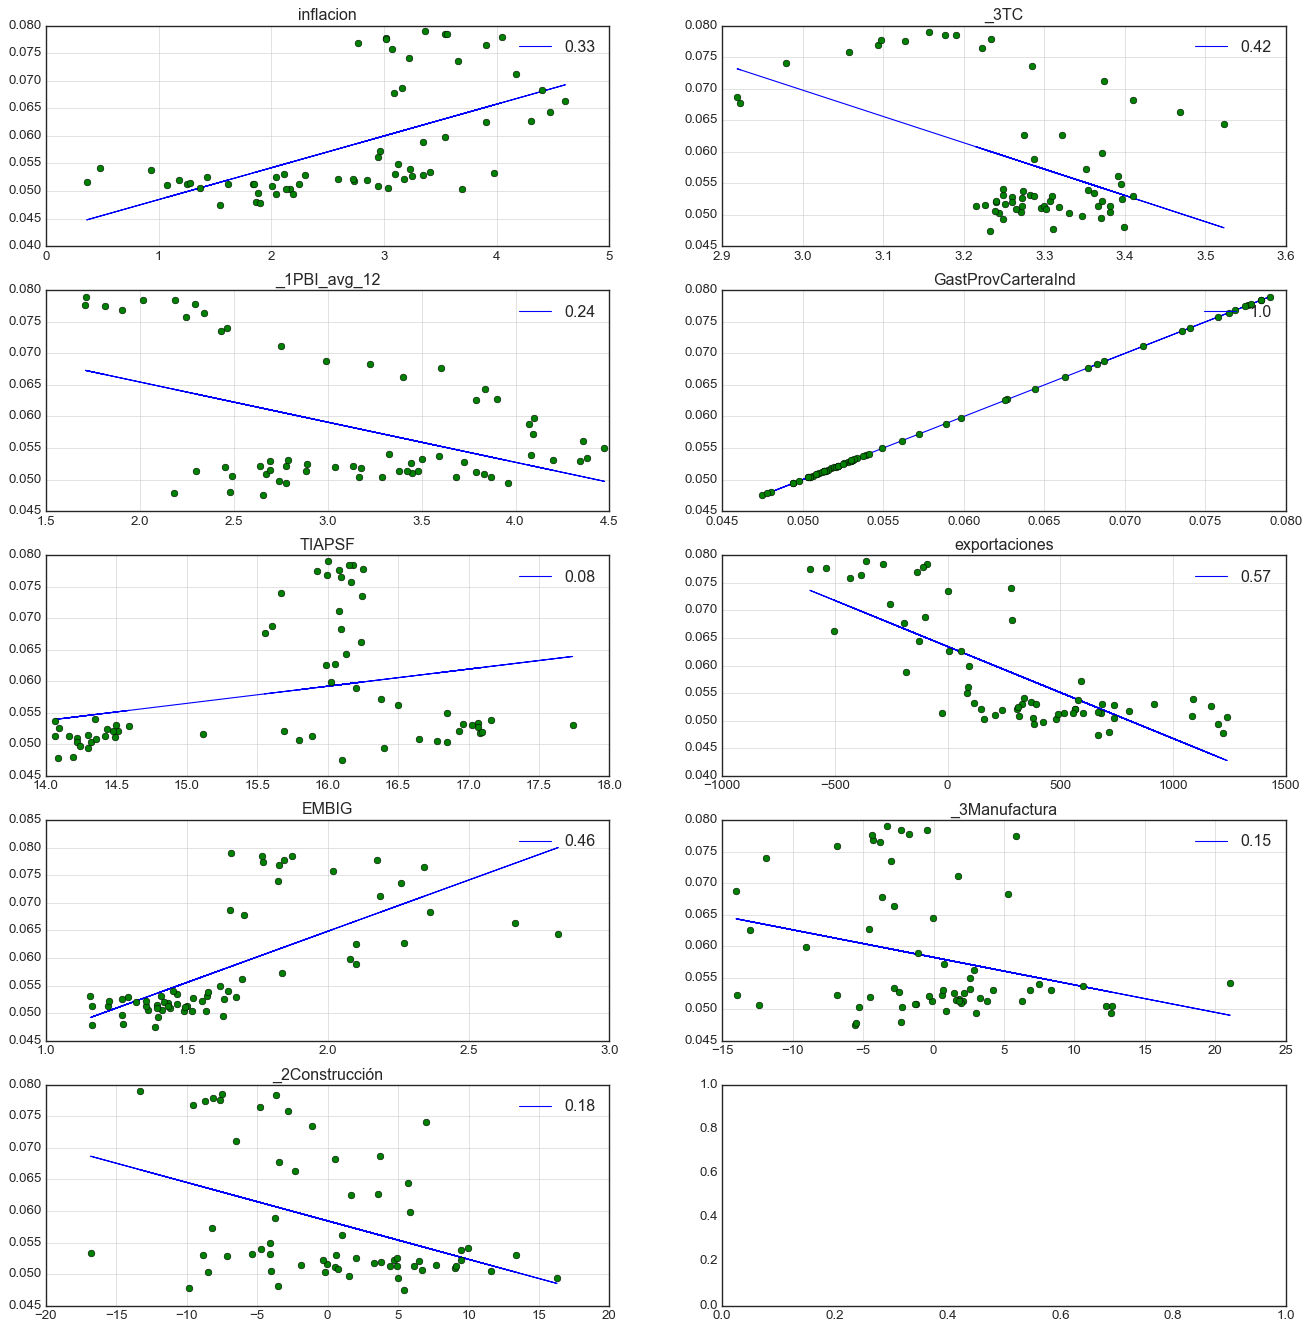

In [1246]:
cuadro,ind=analisis_rezagos(ind,4,dep='GastProvCarteraInd')
cuadro

Eliminando variables con alta orrelación entre ellas 

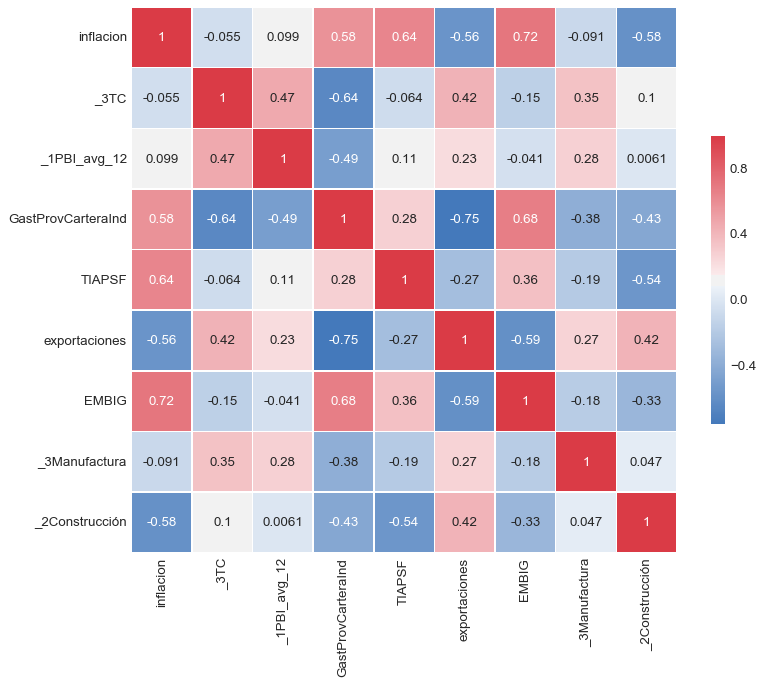

In [1247]:
 CorrMtx(ind)

In [1248]:
y=ind['GastProvCarteraInd']
X=ind.copy()
X.drop('GastProvCarteraInd',axis=1,inplace=True)

In [1249]:
#mod = smf.ols(formula=' GastProvCarteraInd ~   _2credito_sector_privado + _1PBI_avg_12 + _1GastProvCarteraInd  + _2Manufactura + _1Construcción ',data=ind)
mod = sm.OLS(y, X)
res = mod.fit(cov_type='HC3')
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:     GastProvCarteraInd   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1044.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           3.55e-57
Time:                        10:17:06   Log-Likelihood:                 239.63
No. Observations:                  63   AIC:                            -463.3
Df Residuals:                      55   BIC:                            -446.1
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
inflacion         -0.0005      0.001     -0.

Modelo Final

In [1250]:
res,X=ts.back_elimination(y,X,alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:     GastProvCarteraInd   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     81.67
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.04e-24
Time:                        10:17:06   Log-Likelihood:                 268.52
No. Observations:                  63   AIC:                            -525.0
Df Residuals:                      57   BIC:                            -512.2
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1328      0.013     10.496

C:\Users\jcondori\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Variables que tenemos al 2020 : inflacion,tipo de cambio,PBI

In [1251]:
mod = sm.OLS(y, X[['const','inflacion','_3TC', '_1PBI_avg_12']])
res = mod.fit(cov_type='HC3')
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:     GastProvCarteraInd   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     95.82
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           1.19e-22
Time:                        10:17:07   Log-Likelihood:                 250.64
No. Observations:                  63   AIC:                            -493.3
Df Residuals:                      59   BIC:                            -484.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1593      0.014     11.691   

Agregando rezagos de la dependiente

In [1252]:
#ind=pd.concat([X,y],axis=1)

In [1253]:
#ind['GastProvCarteraInd_1']=ind['GastProvCarteraInd'].shift(1)

In [1254]:
#ind.dropna(inplace=True)

In [1255]:
#mod = smf.ols(formula=' GastProvCarteraInd ~ inflacion  +\
#       _3TC +  _1PBI_avg_12 + GastProvCarteraInd_1 ' ,data=ind)
#res = mod.fit()
#print(res.summary())  # No hay mejora 


In [1256]:
#mod = smf.ols(formula=' GastProvCarteraInd ~  +\
#         _1PBI_avg_12  + GastProvCarteraInd_1 ' ,data=ind)
#res = mod.fit()
#print(res.summary())  # No hay mejora 

----------Durbin Watson-------------
Durbin Watson is: 0.3320050716345099


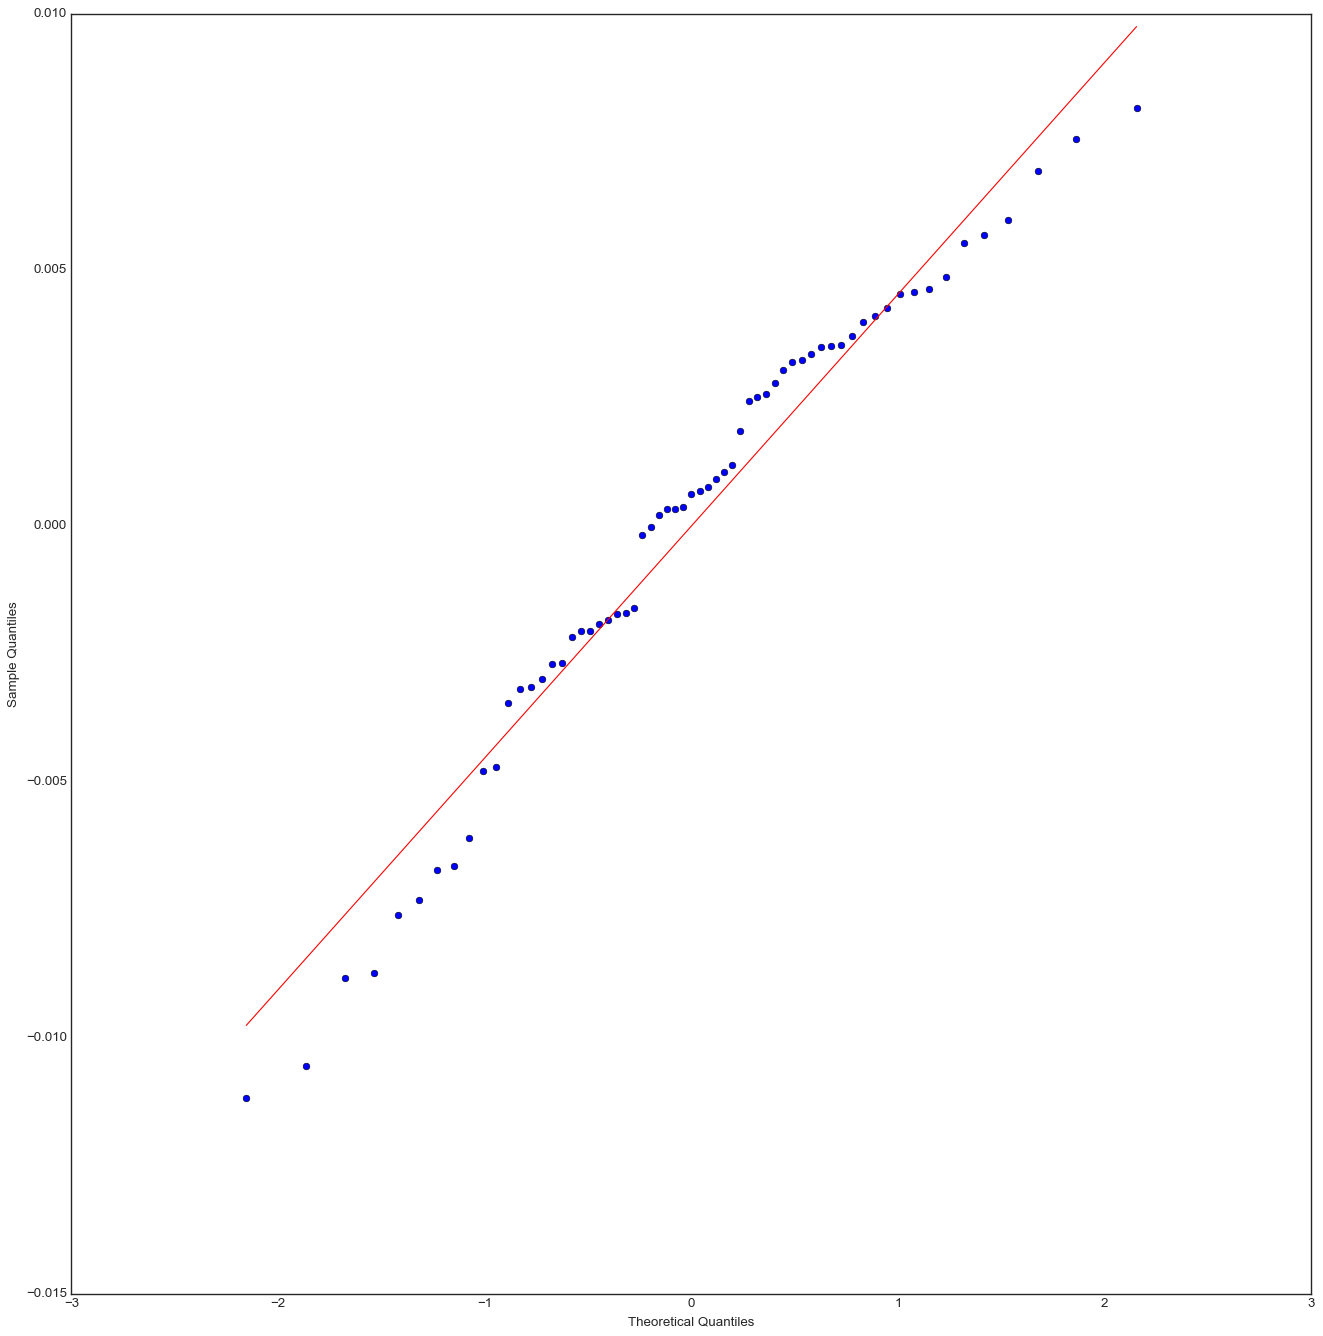

--------Breusch Autocorr-----------
lm: 49.24899738404431
lmpval: 1.892040873814458e-06
fval: 14.027479436082958
fpval: 9.788413981845461e-12
Evidence for autocorrelation
-----White Heteroskedasticity------
{'LM Statistic': 14.47571249992206, 'LM-Test p-value': 0.10638098128524093, 'F-Statistic': 1.7567669076934749, 'F-Test p-value': 0.09904508141340275}
Not Evidence for heteroskedasticity
----------ADF Test-----------------
ADF Statistic: -2.8947161032601954
p-value: 0.04596590203962454
Critical Values:
	1%: -3.542412746661615
	5%: -2.910236235808284
	10%: -2.5927445767266866
Conclusion : Stationary
----------Shapiro Normality--------
Statistics=0.964, p=0.063
Sample looks Gaussian (fail to reject H0)


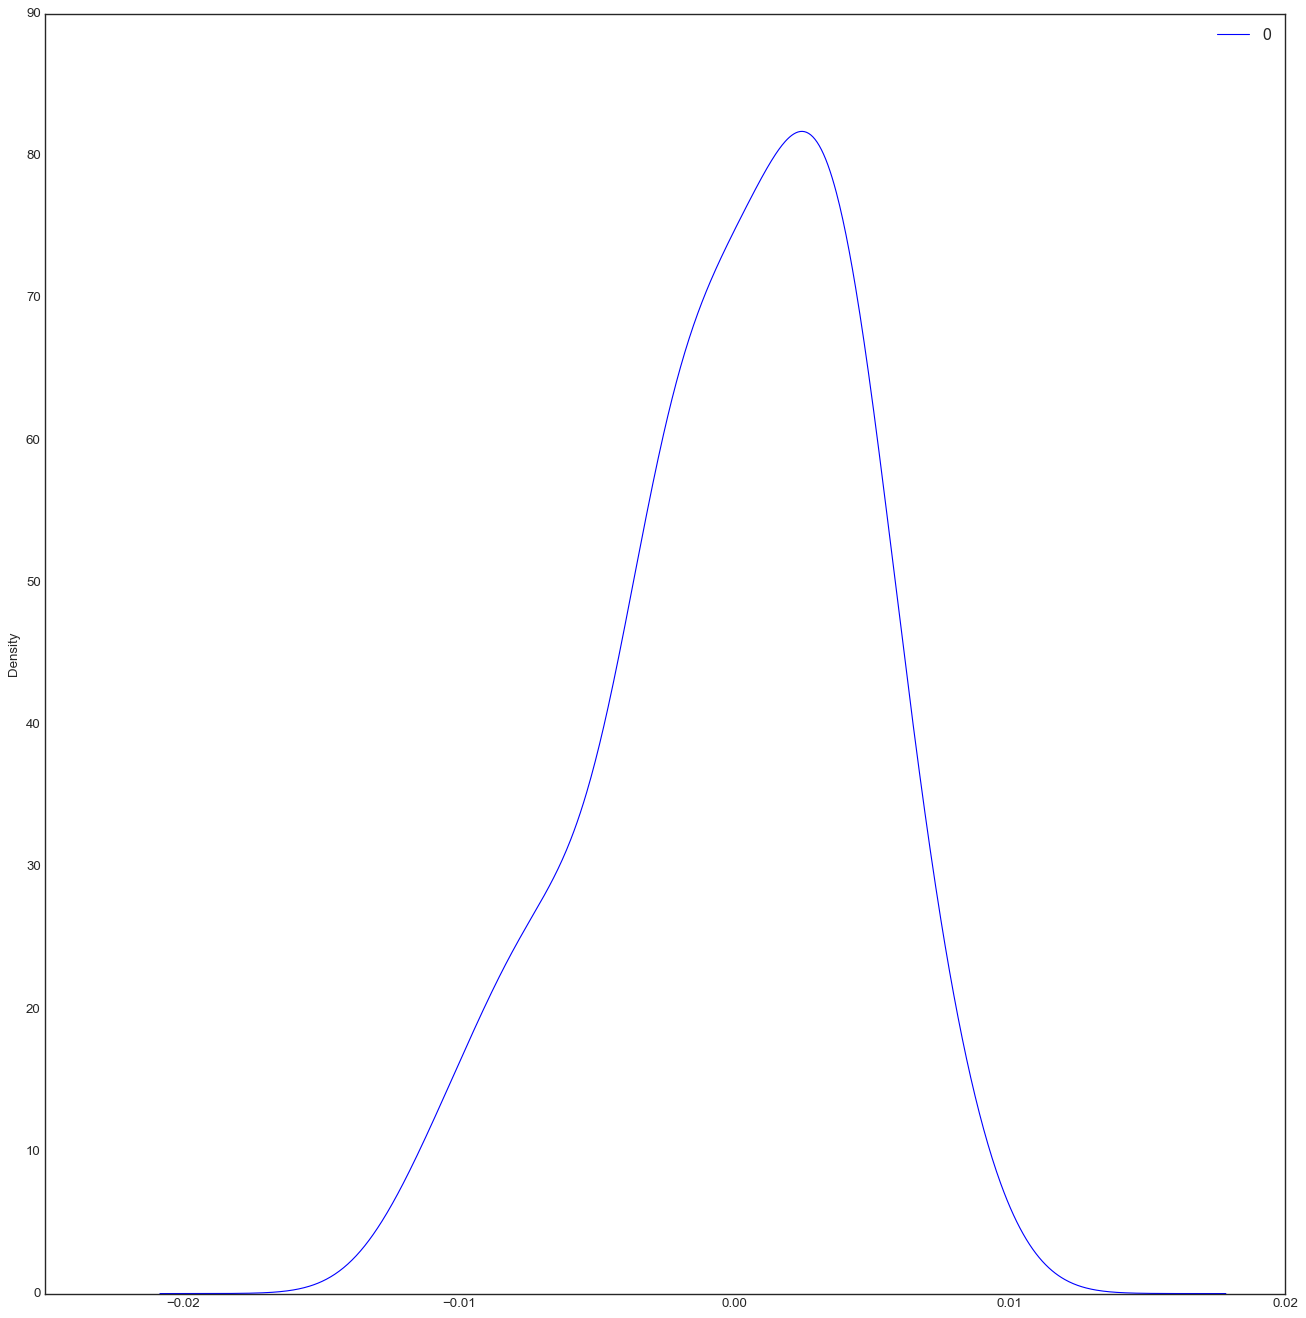

In [1257]:
ts.error_analisis(res,plot=True)

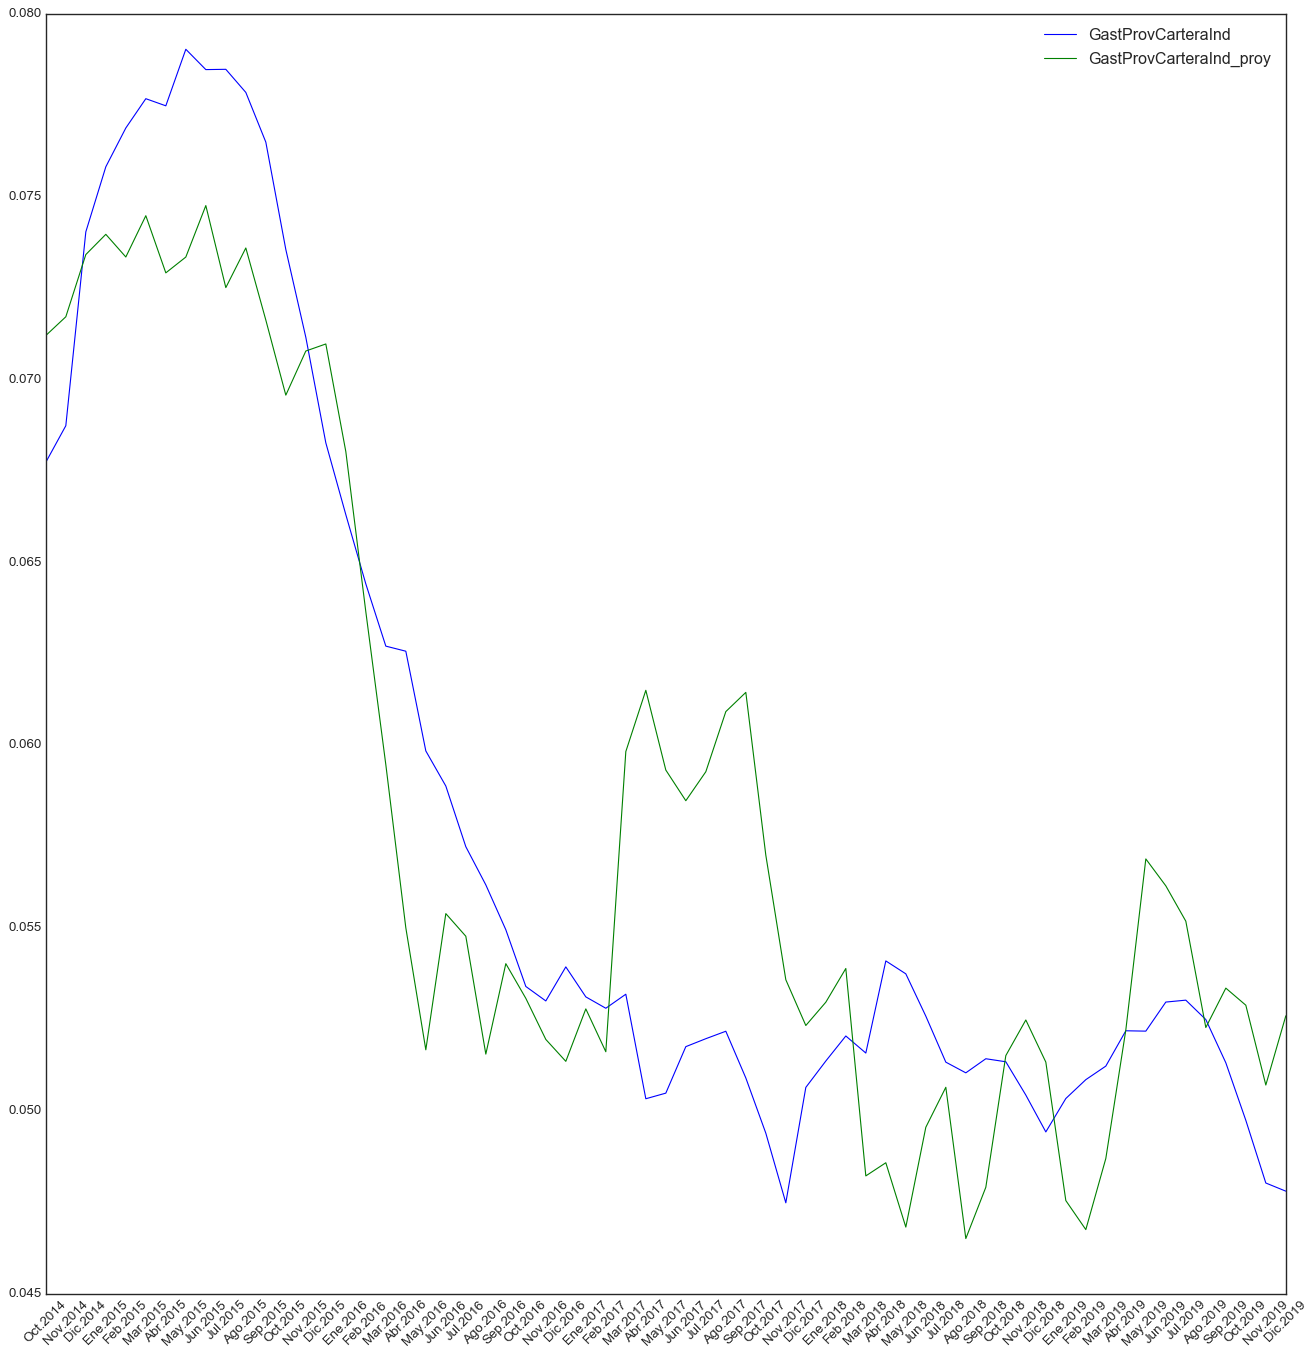

In [1258]:

ind['GastProvCarteraInd_proy']=res.predict()

plt.plot(ind['GastProvCarteraInd'])
plt.plot(ind['GastProvCarteraInd_proy'])
plt.xticks(rotation=45)
plt.legend() # El pbi no parece significativo 

C:\Users\jcondori\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\jcondori\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


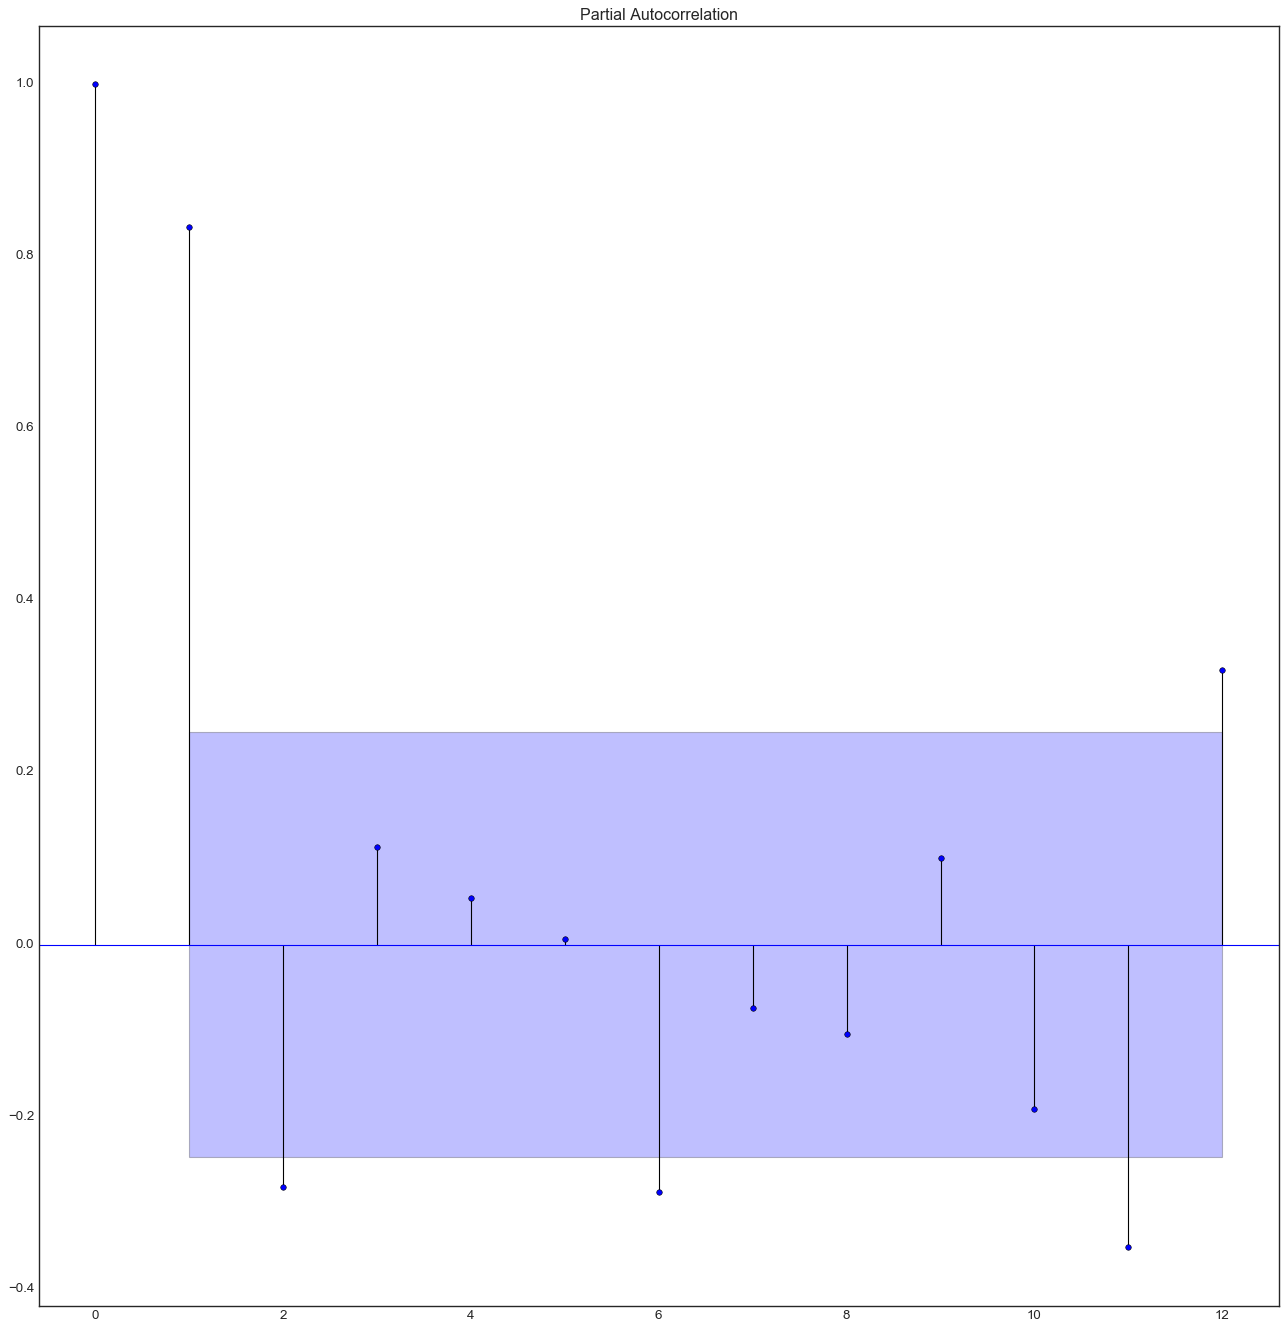

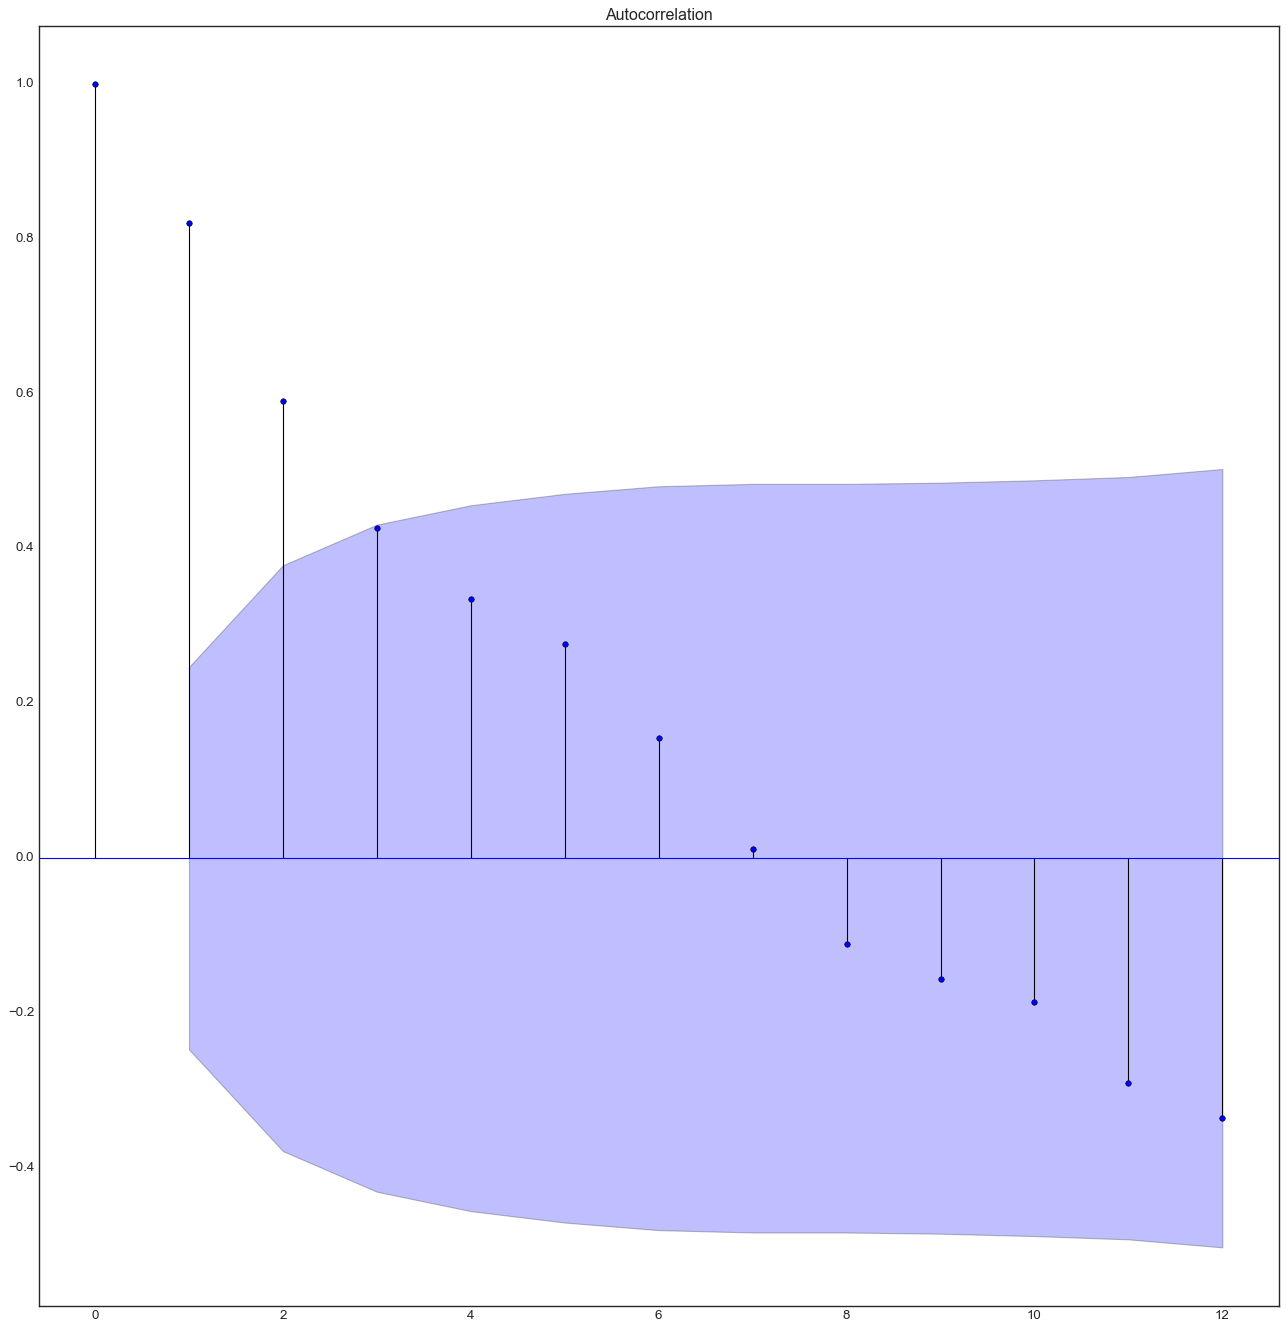

In [1176]:
ts.ac(res)

# Modelo bajo mi método - Con rezagos y diferencias

In [507]:
ind=pd.read_csv('ind.csv')

In [508]:
ind.set_index('Unnamed: 0',inplace=True)

In [382]:
ind=ts.rezagar(ind,n=3,diferencias=True)

In [383]:
ind.dropna(inplace=True)

In [384]:
ind=ind.iloc[:,ind.columns.str.contains("_diff")]

In [385]:
print('numero de variables: ',len(ind.columns))

numero de variables:  63


In [386]:
test=ind.iloc[59:,:]

In [387]:
ind=ind.iloc[:59,:]

# Eliminando correlaciones no significativas con variable de interes

In [388]:
from scipy.stats import pearsonr

In [389]:
a_eliminar=[]
for variable in ind.columns:
    try:
        print('------',variable,'------')
        print(pearsonr(ind[variable],ind['GastProvCarteraInd_diff']))
        if  pearsonr(ind[variable],ind['GastProvCarteraInd_diff'])[1]>0.10:
            a_eliminar.append(variable)
    except:
        pass
print('Variables a eliminar: ',a_eliminar)

------ credito_sector_privado_diff ------
(0.04035389844324063, 0.761542545139363)
------ DIsI_avg_12_diff ------
(-0.22656834566785095, 0.08442174997548776)
------ DIcP_avg_12_diff ------
(-0.40910660362041046, 0.0012943576149257862)
------ inflacion_diff ------
(0.11003599113769834, 0.40674123724508116)
------ TC_diff ------
(-0.01071854591172629, 0.9357827851052929)
------ tasa_ref_diff ------
(-0.19336504087827133, 0.14227412349756588)
------ PBI_avg_12_diff ------
(-0.45148647377232237, 0.000331733793847478)
------ GastProvCarteraInd_diff ------
(1.0, 0.0)
------ Confianza Consumidor_diff ------
(0.13769361877611896, 0.29834967024730424)
------ TIAPSF_diff ------
(-0.06633650801489946, 0.617646493419689)
------ consumo _cemento_diff ------
(-0.040571675889000076, 0.7602939664024951)
------ exportaciones_diff ------
(-0.02133041758463559, 0.8726017094528635)
------ EMBIG_diff ------
(0.06554970446097204, 0.6218324131397501)
------ Agropecuario_diff ------
(0.1663154871498445, 0.208

In [390]:
ind.drop(a_eliminar,axis=1,inplace=True)

In [391]:
ind.columns

Index(['DIsI_avg_12_diff', 'DIcP_avg_12_diff', 'PBI_avg_12_diff',
       'GastProvCarteraInd_diff', 'Comercio_diff', '_1DIsI_avg_12_diff',
       '_2DIsI_avg_12_diff', '_1DIcP_avg_12_diff', '_2DIcP_avg_12_diff',
       '_1inflacion_diff', '_1tasa_ref_diff', '_1PBI_avg_12_diff',
       '_2PBI_avg_12_diff', '_1GastProvCarteraInd_diff',
       '_2GastProvCarteraInd_diff'],
      dtype='object')

# Eliminando variables con alta correlación entre ellas

In [392]:
a_eliminar=[]
for variable_1 in ind.columns:
    for variable_2 in ind.columns:
        #print('Variable 1: ',variable_1,' y Variable 2: ',variable_2)
        #print(pearsonr(ind[variable_1],ind[variable_2]))
        #print('Correlacion de la variable 1 con gasto: ',pearsonr(ind[variable_1],ind['GastProvCarteraInd']))
        #print('Correlacion de la variable 2 con gasto: ',pearsonr(ind[variable_2],ind['GastProvCarteraInd']))
        if  pearsonr(ind[variable_1],ind[variable_2])[0]>0.5 and variable_1 != variable_2  and (variable_1 != 'GastProvCarteraInd_diff' and variable_2 != 'GastProvCarteraInd_diff'):
            if abs(pearsonr(ind[variable_1],ind['GastProvCarteraInd_diff'])[0]) > abs(pearsonr(ind[variable_2],ind['GastProvCarteraInd_diff'])[0]):       
                print('A eliminar: ',variable_2)
                print('Por: ',variable_1)
                print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                a_eliminar.append(variable_2)
            else:
                print('A eliminar: ',variable_1)
                print('Por: ',variable_2)
                print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                a_eliminar.append(variable_1)
a_eliminar=pd.Series(a_eliminar)
a_eliminar= a_eliminar.unique()

A eliminar:  DIsI_avg_12_diff
Por:  DIcP_avg_12_diff
Correlación de:  0.5849251828523028
A eliminar:  DIsI_avg_12_diff
Por:  PBI_avg_12_diff
Correlación de:  0.6743736145045717
A eliminar:  DIsI_avg_12_diff
Por:  _1DIsI_avg_12_diff
Correlación de:  0.7319982390147927
A eliminar:  DIsI_avg_12_diff
Por:  _2DIsI_avg_12_diff
Correlación de:  0.6522472922250707
A eliminar:  DIsI_avg_12_diff
Por:  DIcP_avg_12_diff
Correlación de:  0.5849251828523028
A eliminar:  DIcP_avg_12_diff
Por:  PBI_avg_12_diff
Correlación de:  0.7213675069767985
A eliminar:  _1DIsI_avg_12_diff
Por:  DIcP_avg_12_diff
Correlación de:  0.5476240030881754
A eliminar:  _2DIsI_avg_12_diff
Por:  DIcP_avg_12_diff
Correlación de:  0.5493274423772684
A eliminar:  DIcP_avg_12_diff
Por:  _1DIcP_avg_12_diff
Correlación de:  0.83010721542261
A eliminar:  DIcP_avg_12_diff
Por:  _2DIcP_avg_12_diff
Correlación de:  0.6654882120486112
A eliminar:  DIcP_avg_12_diff
Por:  _1PBI_avg_12_diff
Correlación de:  0.677383970423695
A eliminar:  

In [393]:
a_eliminar 

array(['DIsI_avg_12_diff', 'DIcP_avg_12_diff', '_1DIsI_avg_12_diff',
       '_2DIsI_avg_12_diff', '_1DIcP_avg_12_diff', '_1PBI_avg_12_diff',
       '_2PBI_avg_12_diff', '_2DIcP_avg_12_diff'], dtype=object)

In [394]:
ind.drop(a_eliminar,axis=1,inplace=True)

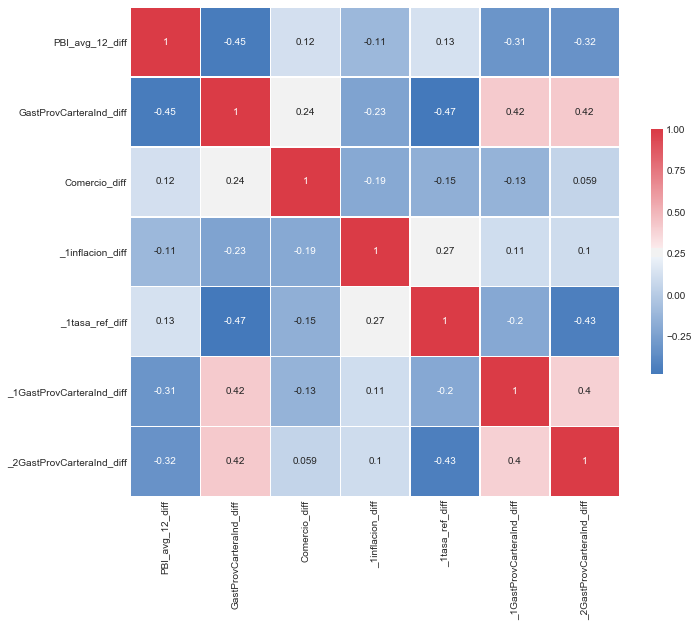

In [395]:
CorrMtx(ind)

# Eliminando signos inversos

In [398]:
ind.columns

Index(['PBI_avg_12_diff', 'GastProvCarteraInd_diff', 'Comercio_diff',
       '_1inflacion_diff', '_1tasa_ref_diff', '_1GastProvCarteraInd_diff',
       '_2GastProvCarteraInd_diff'],
      dtype='object')

In [399]:
ind.drop(['Comercio_diff','_1inflacion_diff','_1tasa_ref_diff'],axis=1,inplace=True)

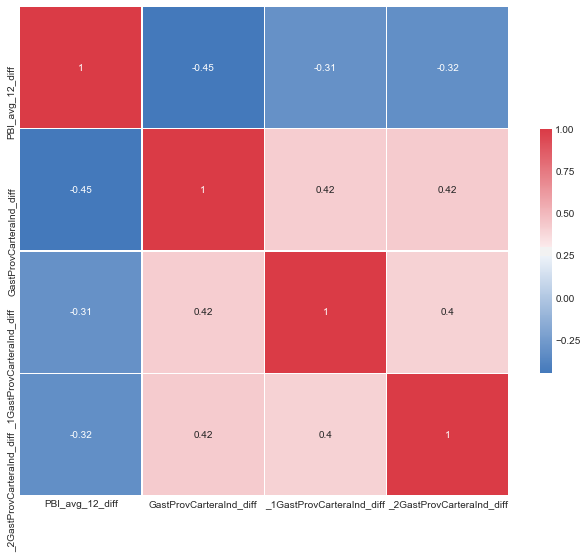

In [400]:
CorrMtx(ind)

# Modelo 

In [401]:
ind.columns

Index(['PBI_avg_12_diff', 'GastProvCarteraInd_diff',
       '_1GastProvCarteraInd_diff', '_2GastProvCarteraInd_diff'],
      dtype='object')

In [402]:

mod = smf.ols(formula=' GastProvCarteraInd_diff ~ PBI_avg_12_diff +\
       _1GastProvCarteraInd_diff +  _2GastProvCarteraInd_diff ' ,data=ind)
res = mod.fit()
print(res.summary())  # No hay mejora 


                               OLS Regression Results                              
Dep. Variable:     GastProvCarteraInd_diff   R-squared:                       0.334
Model:                                 OLS   Adj. R-squared:                  0.298
Method:                      Least Squares   F-statistic:                     9.195
Date:                     Thu, 27 Feb 2020   Prob (F-statistic):           5.00e-05
Time:                             15:03:45   Log-Likelihood:                 311.47
No. Observations:                       59   AIC:                            -614.9
Df Residuals:                           55   BIC:                            -606.6
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Eliminamos la variable 'Demanda interna consumo privado' por p value elevado

----------Durbin Watson-------------
Durbin Watson is: 2.033813237955377


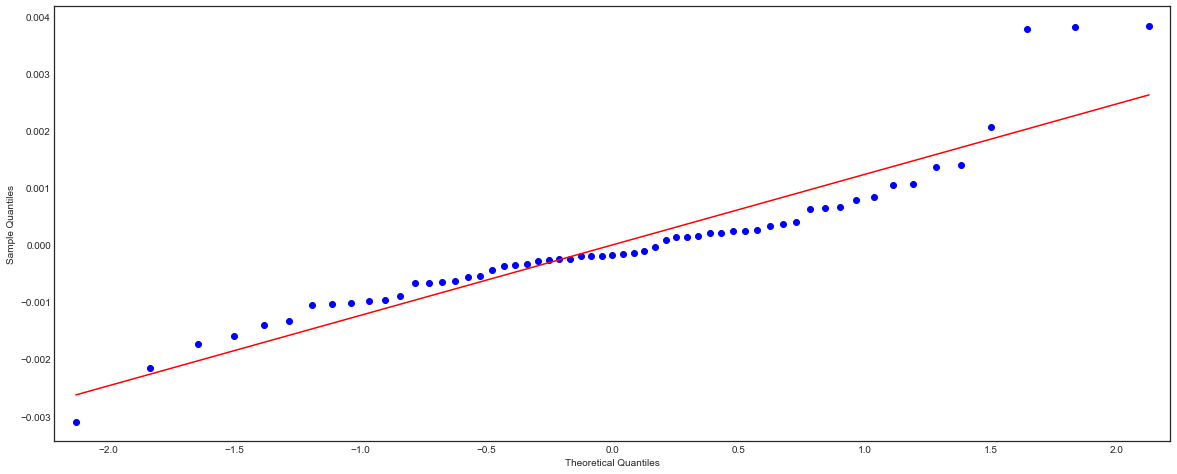

--------Breusch Autocorr-----------
lm: 9.575801482147847
lmpval: 0.6531202106737892
fval: 0.6942609020148085
fpval: 0.7477355298558409
Not Evidence for autocorrelation
-----White Heteroskedasticity------
{'LM Statistic': 8.625672227722823, 'LM-Test p-value': 0.47251997714839267, 'F-Statistic': 0.9322604452831853, 'F-Test p-value': 0.5060978499201052}
Not Evidence for heteroskedasticity
----------ADF Test-----------------
ADF Statistic: -7.704820438493589
p-value: 1.3100887510773577e-11
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944
Conclusion : Stationary
----------Shapiro Normality--------
Statistics=0.892, p=0.000
Sample does not look Gaussian (reject H0)


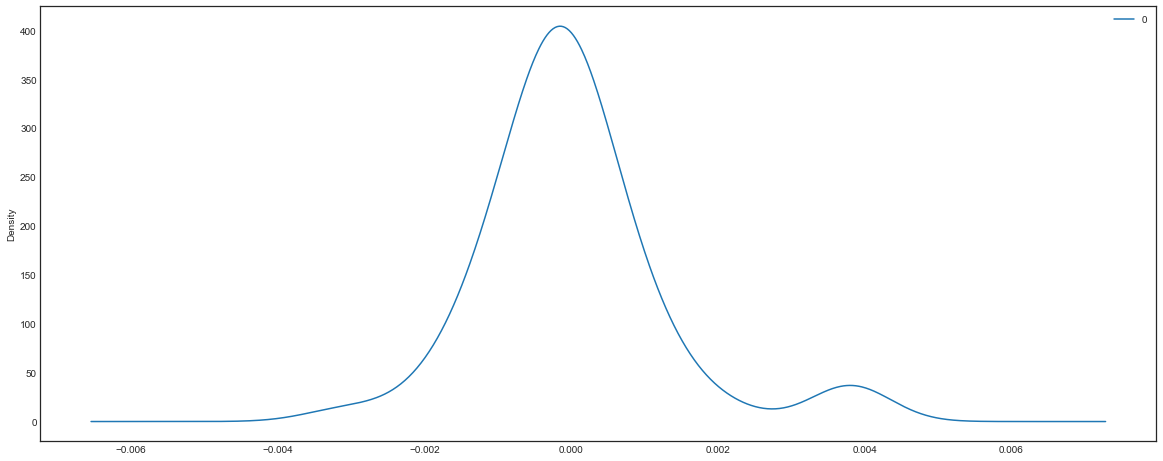

In [403]:
ts.error_analisis(res,plot=True)

In [404]:
mod = smf.ols(formula=' GastProvCarteraInd_diff ~ PBI_avg_12_diff +\
       _1GastProvCarteraInd_diff +  _2GastProvCarteraInd_diff ' ,data=ind)
res = mod.fit()
print(res.summary())  # No hay mejora 


                               OLS Regression Results                              
Dep. Variable:     GastProvCarteraInd_diff   R-squared:                       0.334
Model:                                 OLS   Adj. R-squared:                  0.298
Method:                      Least Squares   F-statistic:                     9.195
Date:                     Thu, 27 Feb 2020   Prob (F-statistic):           5.00e-05
Time:                             15:03:51   Log-Likelihood:                 311.47
No. Observations:                       59   AIC:                            -614.9
Df Residuals:                           55   BIC:                            -606.6
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

# Grafico

In [405]:
plt.rcParams["figure.figsize"] = (20,8)

Train

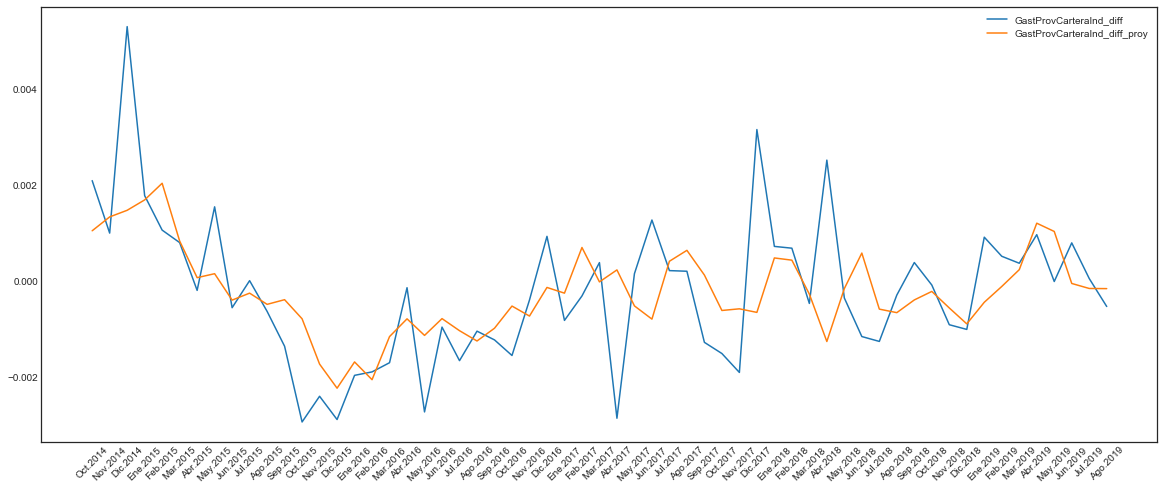

In [406]:

ind['GastProvCarteraInd_diff_proy']=res.predict()

plt.plot(ind['GastProvCarteraInd_diff'])
plt.plot(ind['GastProvCarteraInd_diff_proy'])
plt.xticks(rotation=45)
plt.legend() # El pbi no parece significativo 


Test

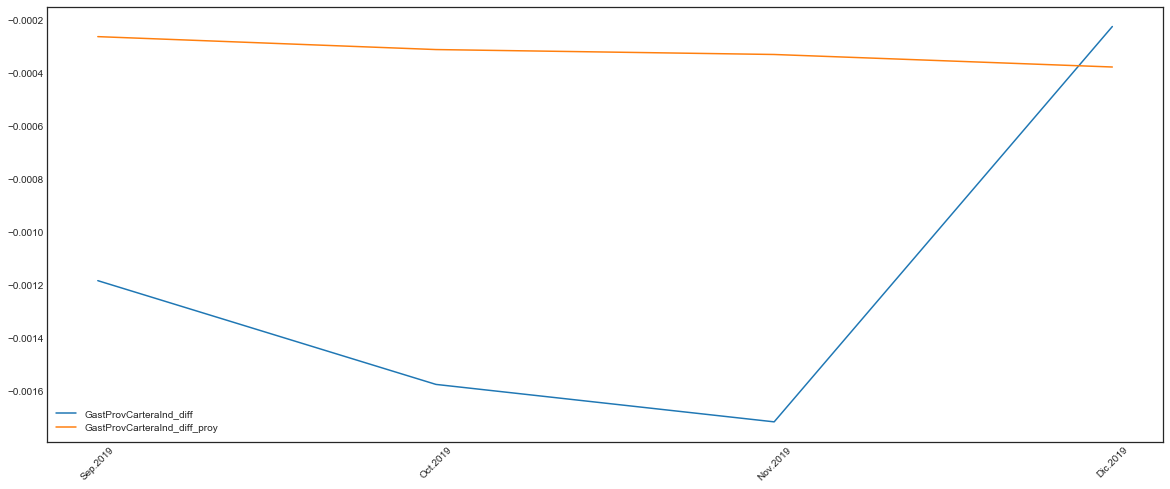

In [407]:
test['GastProvCarteraInd_diff_proy']=res.predict(test)

plt.plot(test['GastProvCarteraInd_diff'])
plt.plot(test['GastProvCarteraInd_diff_proy'])
plt.xticks(rotation=45)
plt.legend() # El pbi no parece significativo 


# <<<< Crecimiento de Cartera Individual >>>>

In [432]:
df=pd.read_csv('df.csv')

ind= df.drop(['Fecha', 'provDesemInd6','moraCosGrup4', 'GastProvCarteraGru', 'GastProvCarteraInd', 'CrecCarGru'],axis=1)

ind.dropna(inplace=True)

In [433]:
ind.set_index('Unnamed: 0',inplace=True)

In [434]:
ind=ts.rezagar(ind,n=3,diferencias=False)

In [435]:
ind.dropna(inplace=True)

In [436]:
ind.reset_index(inplace=True)
ind['mes']=ind['Unnamed: 0'].str[:3]
ind['mes']=ind['mes'].replace('Ene', 1)
ind['mes']=ind['mes'].replace('Feb', 2)
ind['mes']=ind['mes'].replace('Mar', 3)
ind['mes']=ind['mes'].replace('Abr', 4)
ind['mes']=ind['mes'].replace('May', 5)
ind['mes']=ind['mes'].replace('Jun', 6)
ind['mes']=ind['mes'].replace('Jul', 7)
ind['mes']=ind['mes'].replace('Ago', 8)
ind['mes']=ind['mes'].replace('Sep', 9)
ind['mes']=ind['mes'].replace('Oct', 10)
ind['mes']=ind['mes'].replace('Nov', 11)
ind['mes']=ind['mes'].replace('Dic', 12)

ind= ts.monthly_dummie(ind,'mes')

ind.drop(['Unnamed: 0','mes'],axis=1,inplace=True)

ind.rename(columns={0:'Ene'}, inplace=True)
ind.rename(columns={1:'Feb'}, inplace=True)
ind.rename(columns={2:'Mar'}, inplace=True)
ind.rename(columns={3:'Abr'}, inplace=True)
ind.rename(columns={4:'May'}, inplace=True)
ind.rename(columns={5:'Jun'}, inplace=True)
ind.rename(columns={6:'Jul'}, inplace=True)
ind.rename(columns={7:'Ago'}, inplace=True)
ind.rename(columns={8:'Sep'}, inplace=True)
ind.rename(columns={9:'Oct'}, inplace=True)
ind.rename(columns={10:'Nov'}, inplace=True)
ind.rename(columns={11:'Dic'}, inplace=True)

In [437]:
print('numero de variables: ',len(ind.columns))

numero de variables:  75


In [438]:
#test=ind.iloc[59:,:]

In [439]:
#ind=ind.iloc[:59,:]

# Eliminando correlaciones no significativas con variable de interes

In [440]:
a_eliminar=[]
for variable in ind.columns:
    try:
        print('------',variable,'------')
        print(pearsonr(ind[variable],ind['CrecCarInd']))
        if  pearsonr(ind[variable],ind['CrecCarInd'])[1]>0.10:
            a_eliminar.append(variable)
    except:
        pass
print('Variables a eliminar: ',a_eliminar)

------ credito_sector_privado ------
(-0.02738057488730072, 0.8299484899771659)
------ DIsI_avg_12 ------
(0.32125157688280725, 0.009643344848113324)
------ DIcP_avg_12 ------
(-0.2663776541939112, 0.03336806327969306)
------ inflacion ------
(-0.3827004394882564, 0.0018023656502346816)
------ TC ------
(0.2973500444942115, 0.017025287529289716)
------ tasa_ref ------
(-0.3201630186896456, 0.009905857562369112)
------ PBI_avg_12 ------
(0.14919073738238894, 0.2393547706617986)
------ CrecCarInd ------
(1.0, 0.0)
------ Confianza Consumidor ------
(-0.507408243652634, 1.8754368270999074e-05)
------ TIAPSF ------
(-0.34653414067577737, 0.005029784822662496)
------ consumo _cemento ------
(0.5551214335300565, 1.9304843580418834e-06)
------ exportaciones ------
(0.30473205294738437, 0.014351355698291436)
------ EMBIG ------
(-0.38921760545263157, 0.0014792398545067243)
------ Agropecuario ------
(0.15088202367849973, 0.23400961345343882)
------ Pesca ------
(-0.1470839152281899, 0.24612988

In [441]:
ind.drop(a_eliminar,axis=1,inplace=True)

In [442]:
ind.columns

Index(['DIsI_avg_12', 'DIcP_avg_12', 'inflacion', 'TC', 'tasa_ref',
       'CrecCarInd', 'Confianza Consumidor', 'TIAPSF', 'consumo _cemento',
       'exportaciones', 'EMBIG', 'Minería_hidrocarburos', 'Construcción',
       'Otros_servicios', '_1DIsI_avg_12', '_2DIsI_avg_12', '_1DIcP_avg_12',
       '_2DIcP_avg_12', '_1inflacion', '_2inflacion', '_1TC', '_2TC',
       '_1tasa_ref', '_2tasa_ref', '_1CrecCarInd', '_2CrecCarInd',
       '_1Confianza Consumidor', '_2Confianza Consumidor', '_1TIAPSF',
       '_2TIAPSF', '_1consumo _cemento', '_1exportaciones', '_2exportaciones',
       '_1EMBIG', '_2EMBIG', '_2Agropecuario', '_1Construcción',
       '_2Construcción', '_1Otros_servicios', '_2Otros_servicios', 'Abr',
       'Sep', 'Oct', 'Nov', 'Dic'],
      dtype='object')

# Eliminando variables con alta correlación entre ellas

In [443]:
a_eliminar=[]
for variable_1 in ind.columns:
    for variable_2 in ind.columns:
        #print('Variable 1: ',variable_1,' y Variable 2: ',variable_2)
        #print(pearsonr(ind[variable_1],ind[variable_2]))
        #print('Correlacion de la variable 1 con gasto: ',pearsonr(ind[variable_1],ind['GastProvCarteraInd']))
        #print('Correlacion de la variable 2 con gasto: ',pearsonr(ind[variable_2],ind['GastProvCarteraInd']))
        if  pearsonr(ind[variable_1],ind[variable_2])[0]>0.5 and variable_1 != variable_2  and (variable_1 != 'CrecCarInd' and variable_2 != 'CrecCarInd'):
            if abs(pearsonr(ind[variable_1],ind['CrecCarInd'])[0]) > abs(pearsonr(ind[variable_2],ind['CrecCarInd'])[0]):       
                print('A eliminar: ',variable_2)
                print('Por: ',variable_1)
                print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                a_eliminar.append(variable_2)
            else:
                print('A eliminar: ',variable_1)
                print('Por: ',variable_2)
                print('Correlación de: ',pearsonr(ind[variable_1],ind[variable_2])[0])
                a_eliminar.append(variable_1)
a_eliminar=pd.Series(a_eliminar)
a_eliminar= a_eliminar.unique()

A eliminar:  _1DIsI_avg_12
Por:  DIsI_avg_12
Correlación de:  0.965504446511972
A eliminar:  _2DIsI_avg_12
Por:  DIsI_avg_12
Correlación de:  0.8803928486678323
A eliminar:  DIcP_avg_12
Por:  inflacion
Correlación de:  0.55420954469485
A eliminar:  DIcP_avg_12
Por:  EMBIG
Correlación de:  0.567910856621864
A eliminar:  DIcP_avg_12
Por:  _1DIcP_avg_12
Correlación de:  0.9746500247114882
A eliminar:  DIcP_avg_12
Por:  _2DIcP_avg_12
Correlación de:  0.9135543905074686
A eliminar:  DIcP_avg_12
Por:  _1EMBIG
Correlación de:  0.5819417647043243
A eliminar:  DIcP_avg_12
Por:  _2EMBIG
Correlación de:  0.5752882115618625
A eliminar:  _1Otros_servicios
Por:  DIcP_avg_12
Correlación de:  0.5566012396574592
A eliminar:  _2Otros_servicios
Por:  DIcP_avg_12
Correlación de:  0.599012231215311
A eliminar:  DIcP_avg_12
Por:  inflacion
Correlación de:  0.55420954469485
A eliminar:  tasa_ref
Por:  inflacion
Correlación de:  0.7091715331733898
A eliminar:  TIAPSF
Por:  inflacion
Correlación de:  0.6410750

Correlación de:  0.8938698938546503
A eliminar:  Minería_hidrocarburos
Por:  _1tasa_ref
Correlación de:  0.5828450225385429
A eliminar:  _1tasa_ref
Por:  _1inflacion
Correlación de:  0.7058982213154225
A eliminar:  _1tasa_ref
Por:  _2inflacion
Correlación de:  0.7493290077165987
A eliminar:  _1tasa_ref
Por:  _2tasa_ref
Correlación de:  0.9823627951410709
A eliminar:  _1tasa_ref
Por:  _1TIAPSF
Correlación de:  0.8696499748694039
A eliminar:  _1tasa_ref
Por:  _2TIAPSF
Correlación de:  0.8415363864916484
A eliminar:  _1tasa_ref
Por:  _2EMBIG
Correlación de:  0.5377600378882609
A eliminar:  _2tasa_ref
Por:  inflacion
Correlación de:  0.5840296757713098
A eliminar:  _2tasa_ref
Por:  tasa_ref
Correlación de:  0.9623434448772921
A eliminar:  _2tasa_ref
Por:  TIAPSF
Correlación de:  0.9032244072210124
A eliminar:  Minería_hidrocarburos
Por:  _2tasa_ref
Correlación de:  0.5372927748078573
A eliminar:  _2tasa_ref
Por:  _1inflacion
Correlación de:  0.645700642518865
A eliminar:  _2tasa_ref
Por:  

In [444]:
a_eliminar 

array(['_1DIsI_avg_12', '_2DIsI_avg_12', 'DIcP_avg_12',
       '_1Otros_servicios', '_2Otros_servicios', 'tasa_ref', 'TIAPSF',
       'inflacion', 'Minería_hidrocarburos', '_1DIcP_avg_12',
       '_2DIcP_avg_12', '_1inflacion', '_2inflacion', '_1tasa_ref',
       '_2tasa_ref', '_2Confianza Consumidor', '_1TIAPSF', '_2TIAPSF',
       '_1EMBIG', '_2EMBIG', '_1TC', '_2TC', '_1Confianza Consumidor',
       '_1CrecCarInd', '_1consumo _cemento', 'exportaciones',
       '_2CrecCarInd', 'Construcción', '_1exportaciones',
       '_2Construcción'], dtype=object)

In [445]:
ind.drop(a_eliminar,axis=1,inplace=True)

# Eliminando Signos inverso

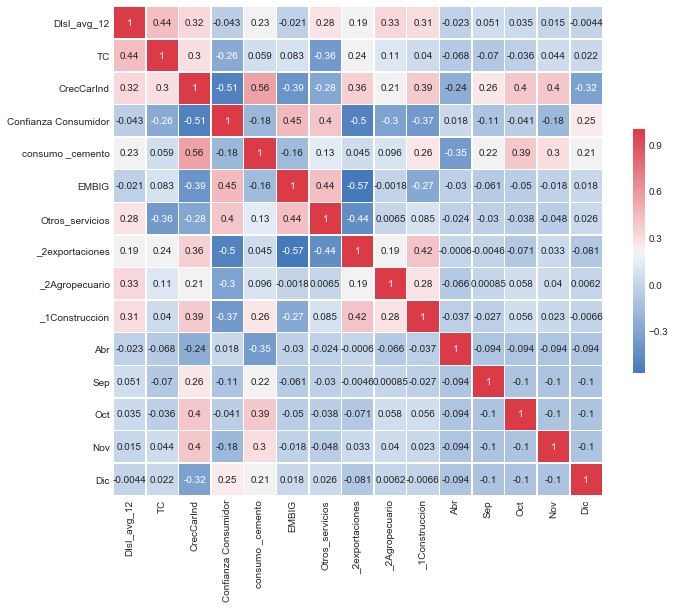

In [446]:
CorrMtx(ind)

In [453]:
ind.drop(['TC','Confianza Consumidor','Otros_servicios'],axis=1,inplace=True)

# Modelo

In [464]:
ind = ind.rename({'consumo _cemento': 'consumo_cemento'}, axis=1)  # new method

In [469]:
ind.columns

Index(['DIsI_avg_12', 'CrecCarInd', 'consumo_cemento', 'EMBIG',
       '_2exportaciones', '_2Agropecuario', '_1Construcción', 'Abr', 'Sep',
       'Oct', 'Nov', 'Dic'],
      dtype='object')

In [470]:
mod = smf.ols(formula=' CrecCarInd ~  consumo_cemento + EMBIG +  _2exportaciones + _2Agropecuario +   _1Construcción + Abr + Sep + Oct  + Nov + Dic + DIsI_avg_12' ,data=ind)
res = mod.fit()
print(res.summary())  


                            OLS Regression Results                            
Dep. Variable:             CrecCarInd   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     16.91
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           1.61e-13
Time:                        16:02:43   Log-Likelihood:                 242.34
No. Observations:                  64   AIC:                            -460.7
Df Residuals:                      52   BIC:                            -434.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0087      0.018     

In [484]:
mod = smf.ols(formula=' CrecCarInd ~   Abr + Sep + Oct  + Nov + Dic + DIsI_avg_12' ,data=ind)
res = mod.fit()
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:             CrecCarInd   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     14.97
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           3.42e-10
Time:                        16:22:48   Log-Likelihood:                 223.94
No. Observations:                  64   AIC:                            -433.9
Df Residuals:                      57   BIC:                            -418.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0037      0.002      1.582      

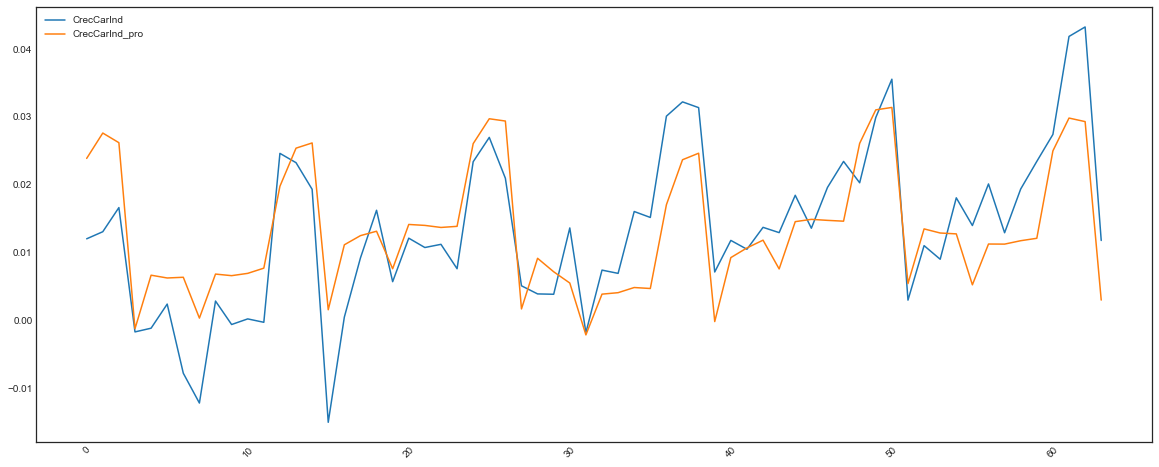

In [485]:
ind['CrecCarInd_pro']=res.predict(ind)

plt.plot(ind['CrecCarInd'])
plt.plot(ind['CrecCarInd_pro'])
plt.xticks(rotation=45)
plt.legend() # El pbi no parece significativo 

In [494]:
df.columns

Index(['Unnamed: 0', 'credito_sector_privado', 'DIsI_avg_12', 'DIcP_avg_12',
       'inflacion', 'TC', 'tasa_ref', 'PBI_avg_12', 'provDesemInd6',
       'GastProvCarteraInd', 'moraCosGrup4', 'GastProvCarteraGru',
       'CrecCarInd', 'CrecCarGru', 'Fecha', 'Confianza Consumidor', 'TIAPSF',
       'consumo _cemento', 'exportaciones', 'EMBIG', 'Agropecuario', 'Pesca',
       'Minería_hidrocarburos', 'Manufactura', 'Electricidad', 'Construcción',
       'Comercio', 'Otros_servicios'],
      dtype='object')

In [497]:
ind=ind.join(df[['PBI_avg_12','tasa_ref']],how='left')

In [481]:
mod = smf.ols(formula=' CrecCarInd ~   Abr + Sep + Oct  + Nov + Dic + PBI_avg_12 ' ,data=ind)
res = mod.fit()
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:             CrecCarInd   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     18.19
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           1.15e-11
Time:                        16:06:26   Log-Likelihood:                 227.90
No. Observations:                  64   AIC:                            -441.8
Df Residuals:                      57   BIC:                            -426.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0224      0.003      7.556      0.0

In [490]:
ind['CrecCarInd_1']=ind['CrecCarInd'].shift(1)
ind.dropna(inplace=True)

In [491]:
mod = smf.ols(formula=' CrecCarInd ~   Abr + Sep + Oct  + Nov + Dic + PBI_avg_12  + CrecCarInd_1 ' ,data=ind)
res = mod.fit()
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:             CrecCarInd   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     30.50
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           9.30e-17
Time:                        16:56:01   Log-Likelihood:                 240.10
No. Observations:                  63   AIC:                            -464.2
Df Residuals:                      55   BIC:                            -447.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0106      0.003      3.506   

In [505]:
mod = smf.ols(formula=' CrecCarInd ~   Abr + Sep + Oct  + Nov + Dic  + PBI_avg_12  + CrecCarInd_1 + tasa_ref ' ,data=ind)
res = mod.fit()
print(res.summary())  

                            OLS Regression Results                            
Dep. Variable:             CrecCarInd   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     26.25
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           5.16e-16
Time:                        18:06:44   Log-Likelihood:                 240.15
No. Observations:                  63   AIC:                            -462.3
Df Residuals:                      54   BIC:                            -443.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0087      0.007      1.168   

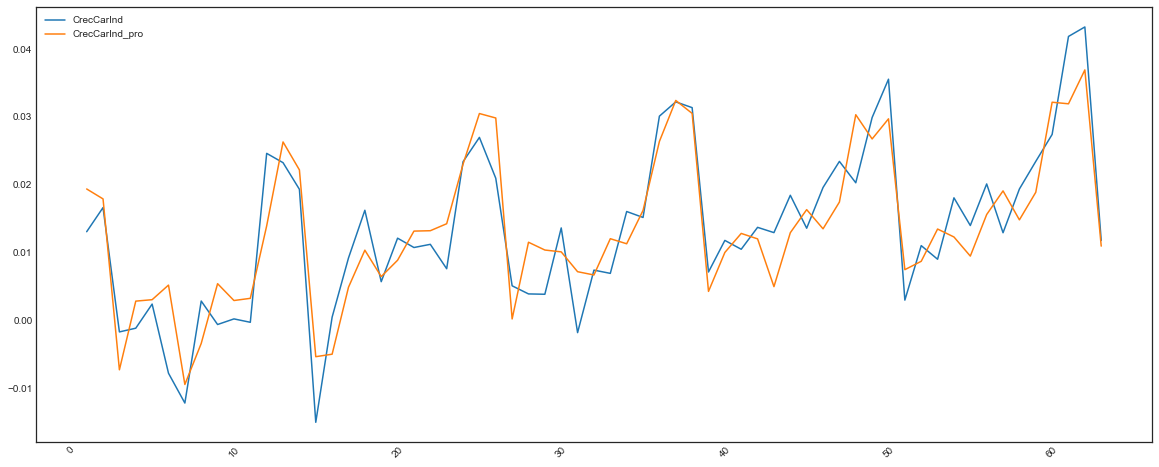

In [500]:
ind['CrecCarInd_pro']=res.predict(ind)

plt.plot(ind['CrecCarInd'])
plt.plot(ind['CrecCarInd_pro'])
plt.xticks(rotation=45)
plt.legend() # El pbi no parece significativo 

----------Durbin Watson-------------
Durbin Watson is: 2.2147143001963756


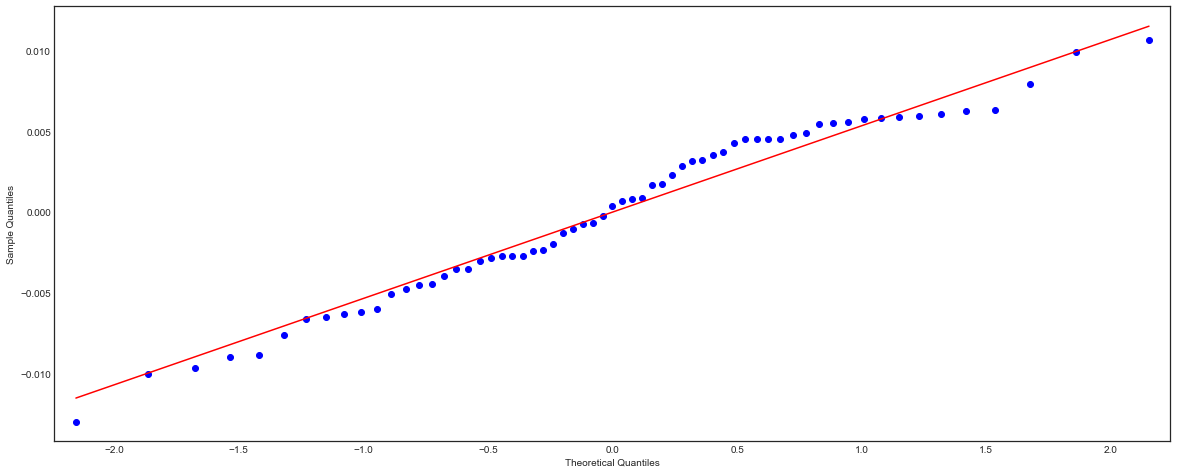

--------Breusch Autocorr-----------
lm: 9.84659095245317
lmpval: 0.6294171363080179
fval: 0.6483698590763608
fpval: 0.788670326885713
Not Evidence for autocorrelation
-----White Heteroskedasticity------
{'LM Statistic': 30.477263260200406, 'LM-Test p-value': 0.39047158612402205, 'F-Statistic': 1.0663624032427268, 'F-Test p-value': 0.4266346217686018}
Not Evidence for heteroskedasticity
----------ADF Test-----------------
ADF Statistic: -8.824371912736535
p-value: 1.840504680040532e-14
Critical Values:
	1%: -3.540522678829176
	5%: -2.9094272025108254
	10%: -2.5923136524453696
Conclusion : Stationary
----------Shapiro Normality--------
Statistics=0.972, p=0.152
Sample looks Gaussian (fail to reject H0)


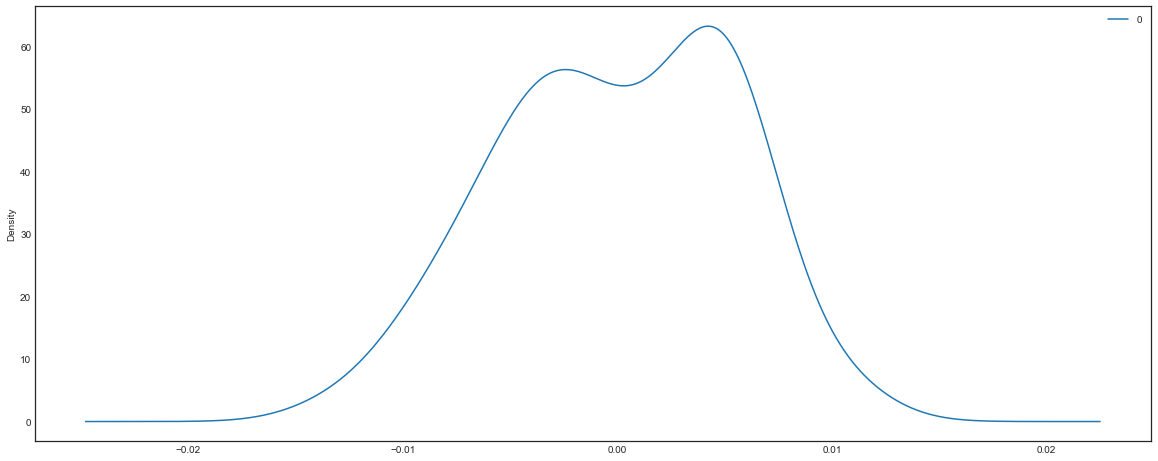

In [501]:
ts.error_analisis(res,plot=True)